In [1]:
!pip install lazypredict

In [165]:
import pandas as pd
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, plot_roc_curve
from matplotlib.pyplot import figure

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [166]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [167]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [168]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [86]:
num_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train['Transported'] = df_train['Transported'].apply(int)
df_train = df_train[num_cols + ['Transported']]
df_test = df_test[num_cols]


In [120]:
# Impute any NA's
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_train[num_cols])
y = df_train['Transported']
X = imputer.transform(df_train[num_cols])
X = pd.DataFrame(X, columns=num_cols)
X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00
1,Earth,False,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00
2,Europa,False,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00
3,Europa,False,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00
4,Earth,False,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00
...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.00,True,0.00,6819.00,0.00,1643.00,74.00
8689,Earth,True,PSO J318.5-22,18.00,False,0.00,0.00,0.00,0.00,0.00
8690,Earth,False,TRAPPIST-1e,26.00,False,0.00,0.00,1872.00,1.00,0.00
8691,Europa,False,55 Cancri e,32.00,False,0.00,1049.00,0.00,353.00,3235.00


In [121]:
X['CryoSleep'] = X['CryoSleep'].apply(int)
X['VIP'] = X['VIP'].apply(int)

In [122]:
lenc_home = LabelEncoder()
lenc_home.fit(X['HomePlanet'])
X['HomePlanet'] = lenc_home.transform(X['HomePlanet'])

lenc_dest = LabelEncoder()
lenc_dest.fit(X['Destination'])
X['Destination'] = lenc_dest.transform(X['Destination'])

X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1,0,2,39.00,0,0.00,0.00,0.00,0.00,0.00
1,0,0,2,24.00,0,109.00,9.00,25.00,549.00,44.00
2,1,0,2,58.00,1,43.00,3576.00,0.00,6715.00,49.00
3,1,0,2,33.00,0,0.00,1283.00,371.00,3329.00,193.00
4,0,0,2,16.00,0,303.00,70.00,151.00,565.00,2.00
...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,41.00,1,0.00,6819.00,0.00,1643.00,74.00
8689,0,1,1,18.00,0,0.00,0.00,0.00,0.00,0.00
8690,0,0,2,26.00,0,0.00,0.00,1872.00,1.00,0.00
8691,1,0,0,32.00,0,0.00,1049.00,0.00,353.00,3235.00


In [123]:
onehot = OneHotEncoder()
onehot.fit(X[['HomePlanet', 'Destination']])
X_hot = pd.DataFrame(onehot.transform(X[['HomePlanet', 'Destination']]).toarray())
X = pd.concat([X_hot, X], axis=1).drop(columns=['HomePlanet', 'Destination'])
X

,0,1,2,3,4,5,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.00,1.00,0.00,0.00,0.00,1.00,0,39.00,0,0.00,0.00,0.00,0.00,0.00
1,1.00,0.00,0.00,0.00,0.00,1.00,0,24.00,0,109.00,9.00,25.00,549.00,44.00
2,0.00,1.00,0.00,0.00,0.00,1.00,0,58.00,1,43.00,3576.00,0.00,6715.00,49.00
3,0.00,1.00,0.00,0.00,0.00,1.00,0,33.00,0,0.00,1283.00,371.00,3329.00,193.00
4,1.00,0.00,0.00,0.00,0.00,1.00,0,16.00,0,303.00,70.00,151.00,565.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.00,1.00,0.00,1.00,0.00,0.00,0,41.00,1,0.00,6819.00,0.00,1643.00,74.00
8689,1.00,0.00,0.00,0.00,1.00,0.00,1,18.00,0,0.00,0.00,0.00,0.00,0.00
8690,1.00,0.00,0.00,0.00,0.00,1.00,0,26.00,0,0.00,0.00,1872.00,1.00,0.00
8691,0.00,1.00,0.00,1.00,0.00,0.00,0,32.00,0,0.00,1049.00,0.00,353.00,3235.00


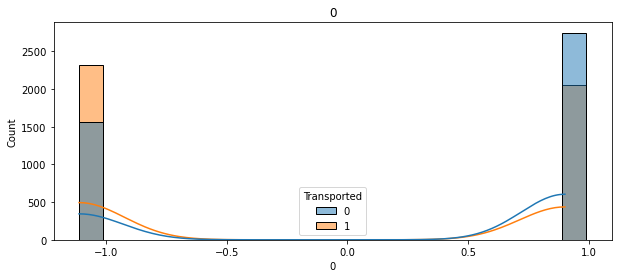

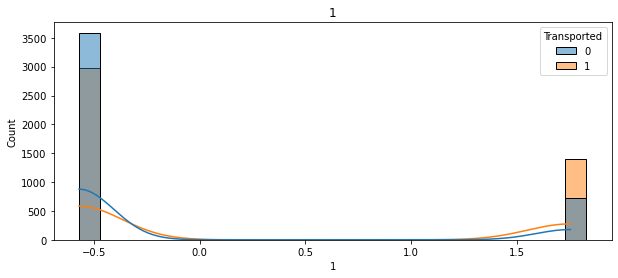

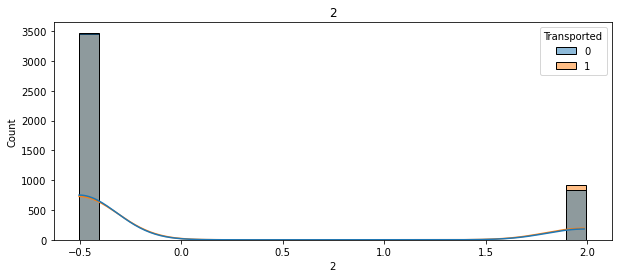

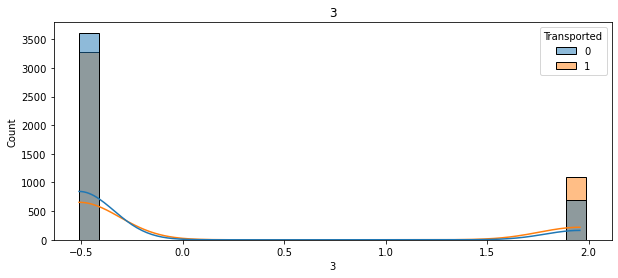

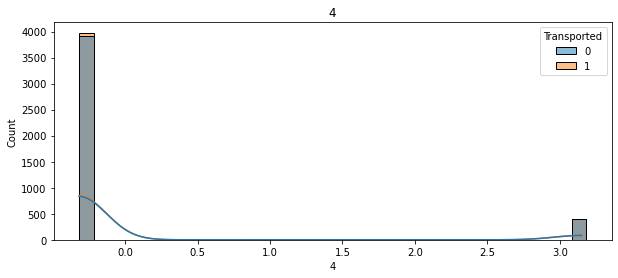

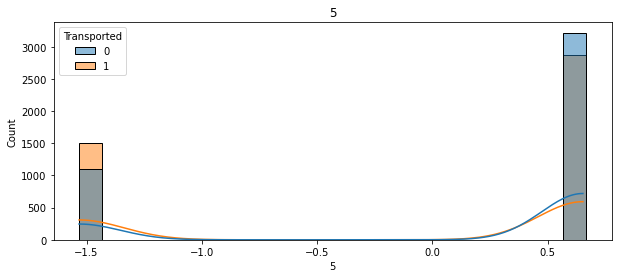

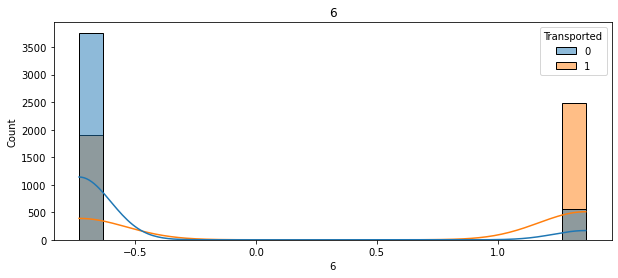

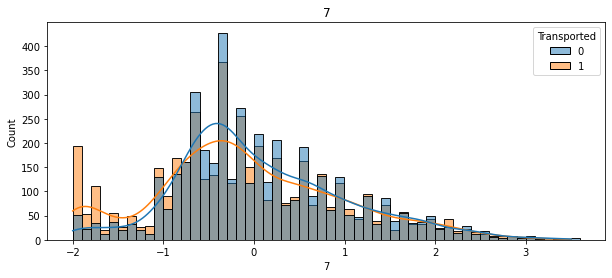

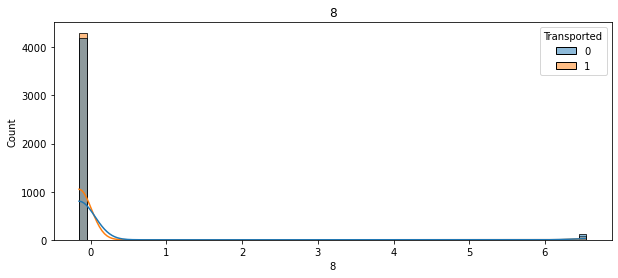

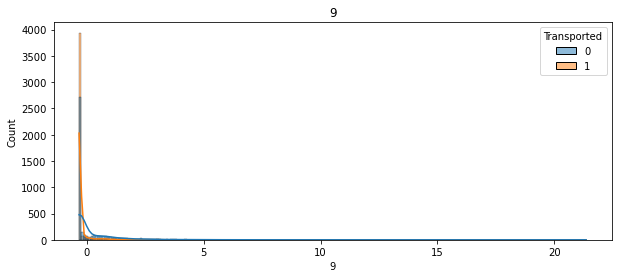

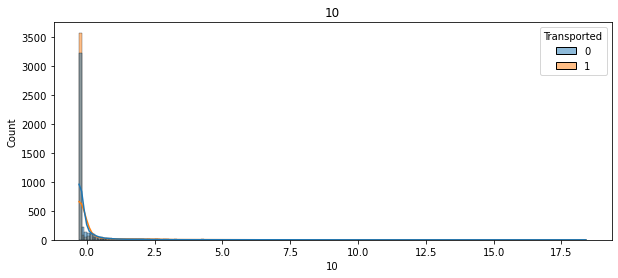

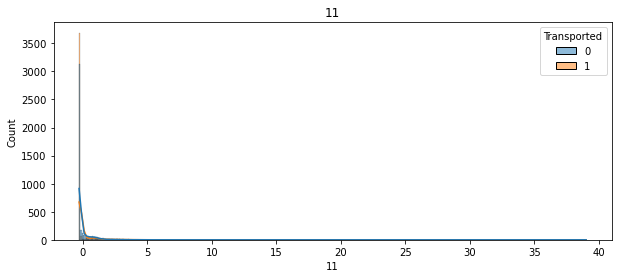

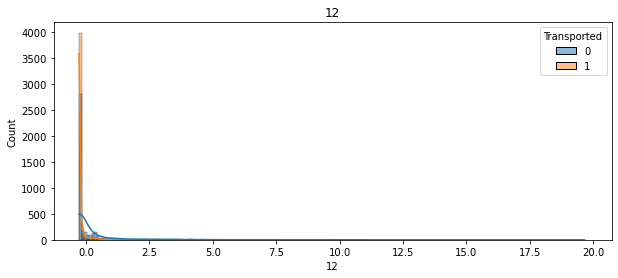

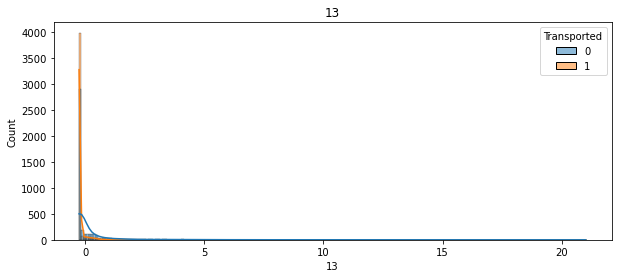

In [199]:
Xy = pd.concat([X, y], axis=1)
for col in X:
    plt.figure(figsize=(10,4))
    # Histogram
    sns.histplot(data=Xy, x=col, hue='Transported', binwidth=0.1, kde=True)
    plt.title(col)
    plt.show()

In [133]:
ss = StandardScaler()
ss.fit(X)
X = pd.DataFrame(ss.transform(X))
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.11,1.75,-0.50,-0.51,-0.32,0.65,-0.73,0.72,-0.15,-0.33,-0.28,-0.28,-0.27,-0.26
1,0.90,-0.57,-0.50,-0.51,-0.32,0.65,-0.73,-0.33,-0.15,-0.17,-0.28,-0.24,0.22,-0.22
2,-1.11,1.75,-0.50,-0.51,-0.32,0.65,-0.73,2.04,6.53,-0.27,1.96,-0.28,5.70,-0.22
3,-1.11,1.75,-0.50,-0.51,-0.32,0.65,-0.73,0.30,-0.15,-0.33,0.52,0.34,2.69,-0.09
4,0.90,-0.57,-0.50,-0.51,-0.32,0.65,-0.73,-0.89,-0.15,0.13,-0.24,-0.03,0.23,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,-1.11,1.75,-0.50,1.96,-0.32,-1.53,-0.73,0.85,6.53,-0.33,3.99,-0.28,1.19,-0.20
8689,0.90,-0.57,-0.50,-0.51,3.15,-1.53,1.36,-0.75,-0.15,-0.33,-0.28,-0.28,-0.27,-0.26
8690,0.90,-0.57,-0.50,-0.51,-0.32,0.65,-0.73,-0.19,-0.15,-0.33,-0.28,2.85,-0.27,-0.26
8691,-1.11,1.75,-0.50,1.96,-0.32,-1.53,-0.73,0.23,-0.15,-0.33,0.38,-0.28,0.04,2.59


In [134]:
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

In [200]:
lc = LazyClassifier(classifiers='all')
lc.fit(X_train , X_test , y_train , y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 LGBMClassifier                     0.79               0.79     0.79      0.79   
 SGDClassifier                      0.78               0.78     0.78      0.78   
 RandomForestClassifier             0.78               0.78     0.78      0.78   
 XGBClassifier                      0.78               0.78     0.78      0.78   
 CalibratedClassifierCV             0.78               0.78     0.78      0.78   
 AdaBoostClassifier                 0.77               0.77     0.77      0.77   
 LogisticRegression                 0.77               0.77     0.77      0.77   
 LinearSVC                          0.77               0.77     0.77      0.77   
 SVC                                0.77               0.77     0.77      0.77   
 ExtraTreesClassifier               0.77               0.77     0.77      0.77   
 BaggingClassifi

In [201]:
lc.models['XGBClassifier']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                   

In [202]:
xgb = lc.models['XGBClassifier']
probs = xgb.predict_proba(X_test)
yhat = probs[:,1]

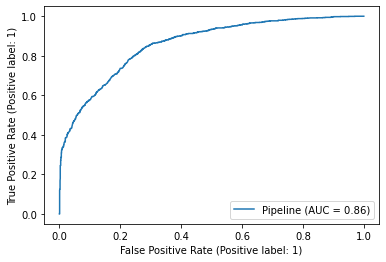

In [203]:
plot_roc_curve(xgb, X_test, y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

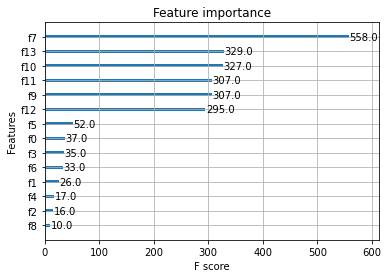

In [204]:
from xgboost import plot_importance
plot_importance(xgb.steps[-1][1])

xgboost.sklearn.XGBClassifier